In [1]:
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from pathlib import Path
from lightly.loss import NTXentLoss
from lightly.models.modules import SimCLRProjectionHead
from lightly.transforms.simclr_transform import SimCLRTransform
import lightly.data as data
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from PIL import Image
import pandas as pd
from torchvision import transforms
from convert_to_image import convert_to_RGB

In [2]:
class SimCLR(pl.LightningModule):
    def __init__(self, out):
        super().__init__()
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.projection_head = SimCLRProjectionHead(512, out, out)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

# Load the saved model
output_size = 32
input_size = 128
current_directory_path = Path.cwd()
directory = current_directory_path.parent /'activity_resistance_ML' / 'processed' 
model_path = current_directory_path / 'sum_32_ver2.pth'
model = SimCLR(output_size)
model.load_state_dict(torch.load(model_path))
model.eval()

# Define the transform (same as used during training)
#transform = SimCLRTransform(input_size=128)

# Function to extract features using the SimCLR model
# def extract_features(image_path):
#     #image = Image.open(image_path).convert('RGB')
#     image = Image.open(image_path)

#     if isinstance(image, list):
#         image = image[0]
#     image = image.unsqueeze(0)  # Add batch dimension
#     with torch.no_grad():
#         features = model(image)
#     return features.squeeze().numpy()



/tmp/ipykernel_1116421/2971712867.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


SimCLR(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [7]:


# Load your labeled data
# Assuming you have a CSV file with image paths and labels
file_name = 'SimCLR_label_img_name.csv'
data = pd.read_csv(file_name)
image_file_name = data['file_name'].tolist()
image_paths = [directory / 'label' / 'GAF_sum' / (i + '.png') for i in image_file_name]
labels = data['ECSA'].tolist()

# Extract features for all images
# features = np.array([extract_features(img_path) for img_path in image_paths])

# print(features)
# print('------------------------')
# print(len(features[0]))
# print('-------------------------')

In [17]:
ex = image_paths[0]
image = Image.open(ex)
image.show()

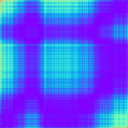

In [19]:
image

In [20]:
image_np = np.array(image)
image_np.shape

(128, 128, 3)

In [21]:
transform = transforms.Compose([
    transforms.ToTensor()  # Convert image to tensor (scales pixel values to [0, 1])
])

# Apply the transformations (convert to tensor)
image_tensor = transform(image).unsqueeze(0)

# Add a batch dimension (since the model expects a batch)
#image_tensor = image_tensor.unsqueeze(0)

# Pass the image tensor to the model to extract features
with torch.no_grad():  # Ensure no gradients are calculated during inference
    features = model(image_tensor)

# Convert features to numpy (if needed) and return or process
features_np = features.squeeze().numpy()

In [22]:
features_np

array([-0.29218817,  0.02460619,  0.43539166,  0.10680223, -0.18684164,
        0.1292146 , -0.0514647 ,  0.08430865, -0.15397172,  0.14269458,
        0.23600195,  0.27294654,  0.18158227,  0.56782657, -0.54672724,
       -0.27837476, -0.00754677, -0.62117803, -0.29508948, -0.05540133,
       -0.08306833,  0.6136855 , -0.18416098, -0.21100467, -0.2918453 ,
       -0.7320207 ,  0.09493124,  0.06488653, -0.00730911, -0.32761875,
        0.95932686,  0.1391867 ], dtype=float32)